# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import straeto
straeto.getBusPositionsFor("1")[0]

{'deviceNumber': 34,
 'gpsFix': 2,
 'gpsTime': '180502192956',
 'heading': 190.03,
 'lastStop': 90000015,
 'lat': 64.1300266666667,
 'lon': -21.9004333333333,
 'nextStop': 10000802,
 'pingCode': 6,
 'route': '1-B',
 'routeNumber': '1',
 'speed': 0.0}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

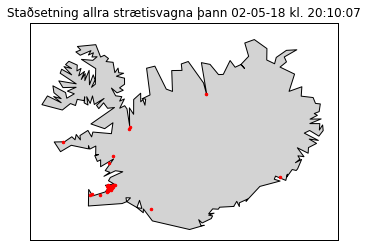

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
import datetime

map = Basemap(projection='merc', resolution='l', urcrnrlon=-12.9, urcrnrlat=66.8, llcrnrlon=-25, llcrnrlat=63.2)
map.drawcoastlines()
map.fillcontinents(color='lightgrey')
map.drawmapboundary()

for bus in straeto.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

In [3]:
!ls

extract_roads  straeto	straeto-notebook.ipynb
